# Noise Generation  
The analytic PSD of noise for three channels are achieved by assuming the euqal arm configuration. 
We can compute the analytic PSD of first-generation TDI channels for LISA by use $\rm{tdi}$ package from the LISA data challenge(LDC) working package.
For an unequal arm configuration, the PSD of noise for three channels are also computed with $\rm{TDInoise}$ package.
We show the PSD of first-generation TDI for LISA and Taiji. 


## Objectives
1. For an equal arm configuration, compute the analytic PSD of first-generation TDI channels for LISA and Taiji 
2. For an unequal arm configuration, compute the PSD of first-generation TDI channels for LISA and Taiji 
3. Generate noise in three channels and  estimate the PSD.

## 1. The PSD of noise
We also import the necessary modules

In [5]:
# coding=utf-8
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys, os, math, time
from astropy.coordinates import SkyCoord
from astropy import units as u
sys.path.append('/disk1/home/wrjx/MLDC-master/software/LDCpipeline/scripts')
from TDInoise import noisepsd_AE_taiji, noisepsd_T_taiji,noisepsd_unequal_A,noisepsd_unequal_E,noisepsd_unequal_T
from pycbc.psd import welch
from pycbc.psd.read import from_numpy_arrays
from pycbc import noise


import LISAConstants as LC
from pyFDresponse import *
# from psd import parse_arguments,Series
from tdi import *
from LISACommonFunctions import *
from GenerateFD_SignalTDIs import *

from psd import parse_arguments,Series


## 1.1 Compute the analytic PSD of LISA for the equal arm configuration with LDC

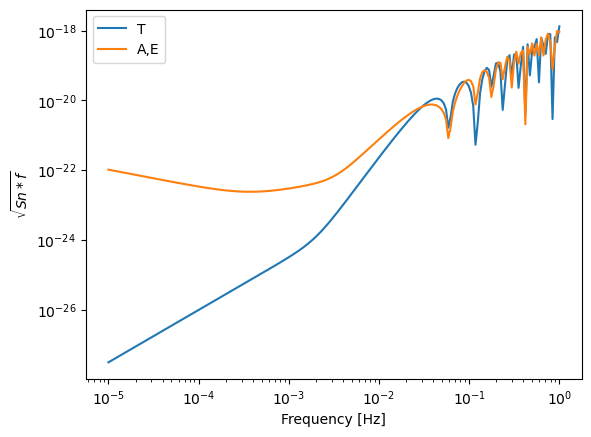

In [6]:
%matplotlib inline
# The PSD for LISA 
df= 1.0/10**6
flen= int(1.0/df)+1
flow=1e-5
freq_data= logsampling(1e-5,1.0,200)
PSD_TDIAE= noisepsd_AE(freq_data)
PSD_TDIT= noisepsd_T(freq_data)
psdAE = from_numpy_arrays(freq_data, PSD_TDIAE, flen, df,flow)
psdT = from_numpy_arrays(freq_data, PSD_TDIT, flen, df,flow)
plt.loglog(freq_data,np.sqrt(PSD_TDIT*freq_data),label='T')
plt.loglog(freq_data,np.sqrt(PSD_TDIAE*freq_data),label='A,E')
plt.legend()
plt.ylabel('$\sqrt{Sn*f}$')
plt.xlabel('Frequency [Hz]')
plt.show()

## 1.2 Compute the analytic PSD of Taiji for the equal arm configuration with TDInoise package

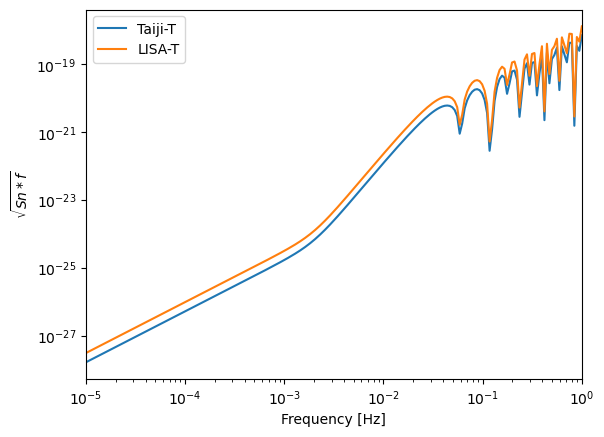

<function matplotlib.pyplot.show(close=None, block=None)>

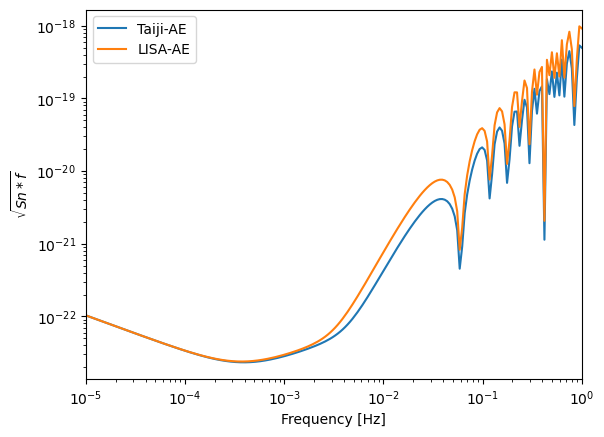

In [7]:
#The PSD of Taiji
PSD_Taiji_TDIAE = noisepsd_AE_taiji(freq_data)
PSD_Taiji_TDIT = noisepsd_T_taiji(freq_data)
psd_taiji_AE = from_numpy_arrays(freq_data, PSD_Taiji_TDIAE, flen, df,flow)
psd_taiji_T = from_numpy_arrays(freq_data, PSD_Taiji_TDIT, flen, df,flow)
plt.loglog(freq_data,np.sqrt(PSD_Taiji_TDIT*freq_data),label='Taiji-T')
plt.loglog(freq_data,np.sqrt(PSD_TDIT*freq_data),label='LISA-T')
plt.ylabel('$\sqrt{Sn*f}$')
plt.xlabel('Frequency [Hz]')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show()

plt.loglog(freq_data,np.sqrt(PSD_Taiji_TDIAE*freq_data),label='Taiji-AE')
plt.loglog(freq_data,np.sqrt(PSD_TDIAE*freq_data),label='LISA-AE')
plt.ylabel('$\sqrt{Sn*f}$')
plt.xlabel('Frequency [Hz]')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show

## 1.3 Compute the PSD of LISA and Taiji for the unequal arm configuration with TDInoise package

Download orbit file.

In [8]:
# Cartesian SSB components of spacecraft positions
path ='/disk1/home/wrjx/LitePIG'
p1 = np.fromfile(path+'/signal/LISA_orbit_data/SCP1_1yr.dat',sep=' ')
p2 = np.fromfile(path+'/signal/LISA_orbit_data/SCP2_1yr.dat',sep=' ')
p3 = np.fromfile(path+'/signal/LISA_orbit_data/SCP3_1yr.dat',sep=' ')
p1= p1.reshape(int(len(p1)/3),3)
p2= p2.reshape(int(len(p2)/3),3)
p3= p3.reshape(int(len(p3)/3),3)

#equatorial coordinate system 
from matplotlib.ticker import LinearLocator
c1= SkyCoord(x=p1[:,0],y=p1[:,1],z=p1[:,2],unit=u.au,frame='icrs',representation_type='cartesian')
c2= SkyCoord(x=p2[:,0],y=p2[:,1],z=p2[:,2],unit=u.au,frame='icrs',representation_type='cartesian')
c3= SkyCoord(x=p3[:,0],y=p3[:,1],z=p3[:,2],unit=u.au,frame='icrs',representation_type='cartesian')
#print(c1)
#transfrom to Ecliptic system of coordinate
p1_SSB= c1.heliocentrictrueecliptic
p2_SSB= c2.heliocentrictrueecliptic
p3_SSB= c3.heliocentrictrueecliptic
p1_SSB.representation_type='cartesian'
p2_SSB.representation_type='cartesian'
p3_SSB.representation_type='cartesian'

#interpolate 
def funcp_SSB(t,p_SSB):
    year=np.linspace(0,LC.YRSID_SI,366)
    px_SSB= spline(year,p_SSB.x)
    py_SSB= spline(year,p_SSB.y)
    pz_SSB= spline(year,p_SSB.z)
    return np.array([px_SSB(t),py_SSB(t),pz_SSB(t)]) 

#Computing the arm length
def funcL_SSB(p1_SSB,p2_SSB):
    Ln = p2_SSB- p1_SSB
    L = np.sqrt(Ln[0]**2+Ln[1]**2+Ln[2]**2)
    return L

def funcp0_SSB(t,p1_SSB=p1_SSB,p2_SSB=p2_SSB,p3_SSB=p3_SSB):
    p1= funcp_SSB(t,p1_SSB)*R_SI
    p2= funcp_SSB(t,p2_SSB)*R_SI
    p3= funcp_SSB(t,p3_SSB)*R_SI
    p0 = (p1+p2+p3)/3
    return p0

trajdict_numerical_orbits = {
    'funcp0':funcp0_SSB,
    'funcp': funcp_SSB,
    'funcL': funcL_SSB,
    'p1_SSB': p1_SSB,
    'p2_SSB': p2_SSB,
    'p3_SSB': p3_SSB,
    }

In [9]:
t0= 0.05
tmp_year= t0* YRSID_SI
tmp_p0 = funcp0_SSB(tmp_year,p1_SSB=p1_SSB,p2_SSB=p2_SSB,p3_SSB=p3_SSB)
tmp_p1= funcp_SSB(tmp_year,p1_SSB)*R_SI
tmp_p2= funcp_SSB(tmp_year,p2_SSB)*R_SI
tmp_p3= funcp_SSB(tmp_year,p3_SSB)*R_SI

L12= funcL_SSB(tmp_p1,tmp_p2)
L23= funcL_SSB(tmp_p2,tmp_p3)
L13= funcL_SSB(tmp_p1,tmp_p3)
print(L12,L23,L13)

2498586342.3961334 2491018378.559804 2515608597.9621577


<Figure size 640x480 with 0 Axes>

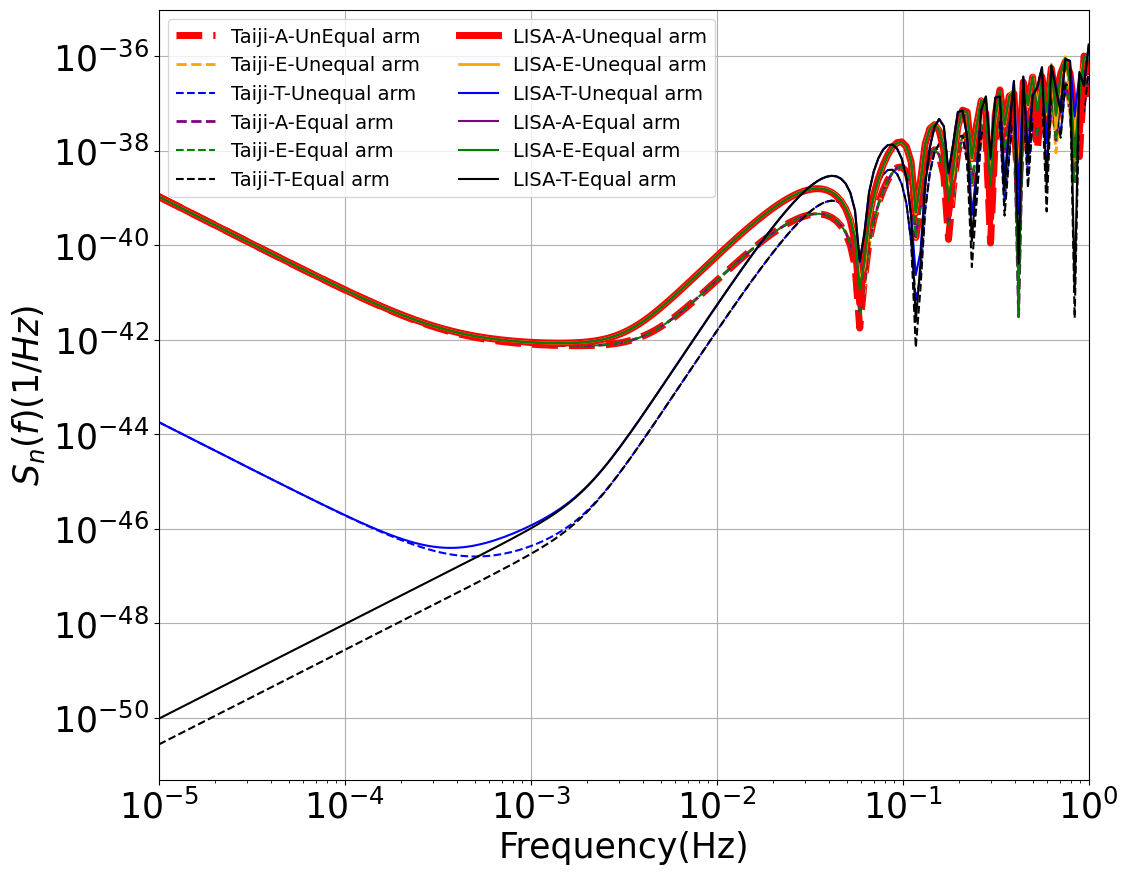

In [10]:
PSD_A_Taiji_uneq = noisepsd_unequal_A(freq_data,L12,L23,L13,'Taiji')
PSD_E_Taiji_uneq = noisepsd_unequal_E(freq_data,L12,L23,L13,'Taiji')
PSD_T_Taiji_uneq = noisepsd_unequal_T(freq_data,L12,L23,L13,'Taiji')
PSD_A_LISA_uneq = noisepsd_unequal_A(freq_data,L12,L23,L13,'LISA')
PSD_E_LISA_uneq = noisepsd_unequal_E(freq_data,L12,L23,L13,'LISA')
PSD_T_LISA_uneq = noisepsd_unequal_T(freq_data,L12,L23,L13,'LISA')
color=['red','orange','blue','purple','green','black']
fig=plt.figure()
f, ax = plt.subplots(1, 1, figsize=[12,10])
plt.loglog(freq_data,PSD_A_Taiji_uneq,label='Taiji-A-UnEqual arm',linestyle='--',color=color[0],linewidth=5)
plt.loglog(freq_data,PSD_E_Taiji_uneq,label='Taiji-E-Unequal arm',linestyle='--',color=color[1],linewidth=2)
plt.loglog(freq_data,PSD_T_Taiji_uneq,label='Taiji-T-Unequal arm',linestyle='--',color=color[2])
plt.loglog(freq_data,PSD_Taiji_TDIAE,label='Taiji-A-Equal arm',linestyle='--',color=color[3],linewidth=2)
plt.loglog(freq_data,PSD_Taiji_TDIAE,label='Taiji-E-Equal arm',linestyle='--',color=color[4])
plt.loglog(freq_data,PSD_Taiji_TDIT,label='Taiji-T-Equal arm',linestyle='--',color=color[5])
plt.loglog(freq_data,PSD_A_LISA_uneq,label='LISA-A-Unequal arm',color=color[0],linewidth=5)
plt.loglog(freq_data,PSD_E_LISA_uneq,label='LISA-E-Unequal arm',color=color[1],linewidth=2)
plt.loglog(freq_data,PSD_T_LISA_uneq,label='LISA-T-Unequal arm',color=color[2])
plt.loglog(freq_data,PSD_TDIAE,label='LISA-A-Equal arm',color=color[3])
plt.loglog(freq_data,PSD_TDIAE,label='LISA-E-Equal arm',color=color[4])
plt.loglog(freq_data,PSD_TDIT,label='LISA-T-Equal arm',color=color[5])
plt.xlabel('Frequency(Hz)',fontsize=25)
plt.ylabel('$S_{n}(f)(1/Hz)$',fontsize=25)
plt.tick_params(labelsize=25)
plt.grid()
plt.xlim(1e-5,1e-0)
plt.legend(ncol=2,prop={'size':14})
plt.show()

## 2 Generate noise in three channels

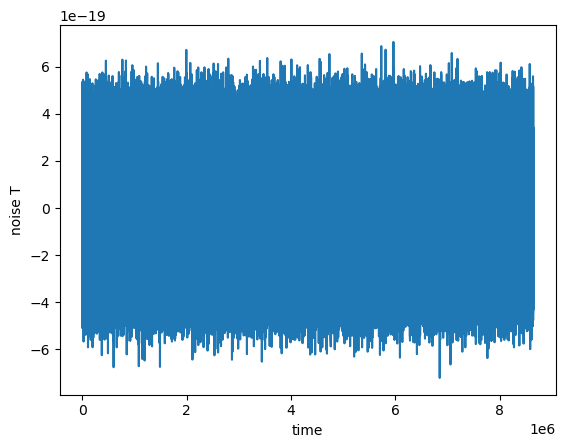

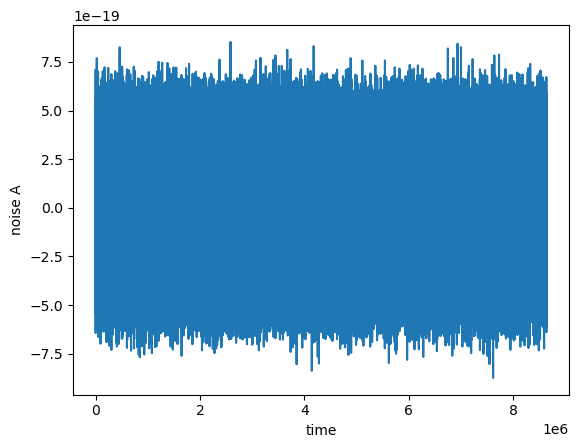

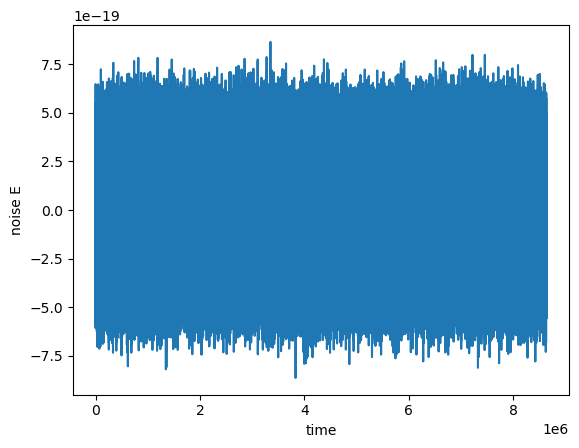

In [11]:
### Generate 100days of noise 
Tobs=3600*24*100
del_t= 1
tsamples = int(Tobs / del_t)
noiseT = noise.noise_from_psd(tsamples, del_t, psdT)
noiseA = noise.noise_from_psd(tsamples, del_t, psdAE)
noiseE = noise.noise_from_psd(tsamples, del_t, psdAE)
plt.plot(noiseT.sample_times, noiseT)
plt.xlabel('time')
plt.ylabel('noise T')
plt.show()

plt.plot(noiseT.sample_times, noiseA)
plt.xlabel('time')
plt.ylabel('noise A')
plt.show()

plt.plot(noiseT.sample_times, noiseE)
plt.xlabel('time')
plt.ylabel('noise E')
plt.show()

## 1.3 Estimate the PSD of a time series

Computing PSD for T (using 8640000 points at 1.0 Hz)...
Computing PSD for A (using 8640000 points at 1.0 Hz)...


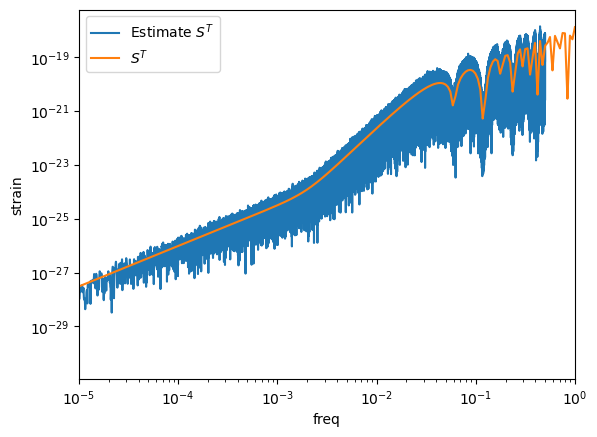

<function matplotlib.pyplot.show(close=None, block=None)>

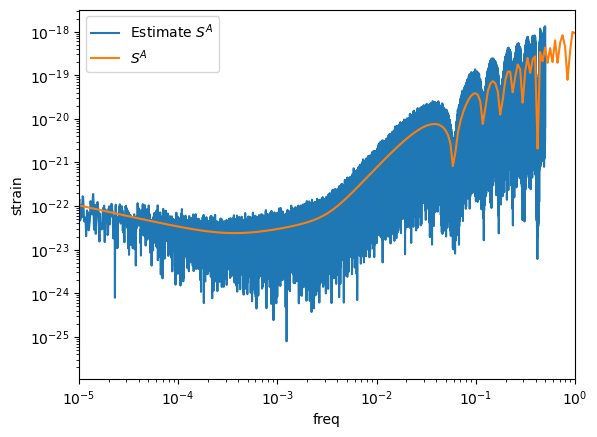

In [16]:
noise_T =Series(noiseT.sample_times,noiseT,'T')
psdT_estimated= noise_T.compute(nperseg=None, overlap=0.5, window='nuttall')

noise_A =Series(noiseA.sample_times,noiseA,'A')
psdA_estimated= noise_A.compute(nperseg=None, overlap=0.5, window='nuttall')


# seg_len = int(1000000 / del_t)
# seg_stride = int(seg_len / 2)
# psdA_estimated = welch(noiseA,
#                       seg_len=seg_len,
#                       seg_stride=seg_stride,
#                       avg_method='mean')
# psdT_estimated = welch(noiseT,
#                       seg_len=seg_len,
#                       seg_stride=seg_stride,
#                       avg_method='mean')
plt.loglog(psdT_estimated.frequencies,np.sqrt(psdT_estimated.psd*psdT_estimated.frequencies),label='Estimate $S^{T}$')
# plt.loglog(psdT_estimated.sample_frequencies,np.sqrt(psdT_estimated*psdT_estimated.sample_frequencies),label='Estimate $S^{T}$')
plt.loglog(psdT.sample_frequencies,np.sqrt(psdT*psdT.sample_frequencies),label='$S^{T}$')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show()
plt.loglog(psdA_estimated.frequencies,np.sqrt(psdA_estimated.psd*psdA_estimated.frequencies),label='Estimate $S^{A}$')
# plt.loglog(psdA_estimated.sample_frequencies,np.sqrt(psdA_estimated*psdA_estimated.sample_frequencies),label='Estimate $S^{A}$')
plt.loglog(psdAE.sample_frequencies,np.sqrt(psdAE*psdAE.sample_frequencies),label='$S^{A}$')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show